# VGGish11 Sound Classification Inference

This notebook demonstrates an end-to-end sound classification pipeline using a VGGish-based model compiled for TIDL.

**Pipeline:**
1.  **Load Audio:** Load a `.wav` audio file.
2.  **Play Audio and Visualize Waveform:** Play the loaded audio sample and display the audio waveform.
3.  **Preprocess, Extract Features, Visualize Features:** Convert audio to log mel spectrogram features using imported function. Display the log mel spectrogram.
4.  **Run Inference:** Load the ONNX model and perform inference using ONNX Runtime with TIDL delegate via imported function.
5.  **Display Results:** Show the top predicted classes and their probabilities. Report inference performance metrics from TIDL (output generated by imported function).

In [1]:
import os

# Suppress ONNX Runtime GPU discovery warning (no GPU on this platform)
os.environ['ORT_DISABLE_DEVICE_DISCOVERY'] = '1'

import sys
import time
import numpy as np
import torch
import torchaudio
import onnxruntime as ort
import platform
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from datetime import datetime
import vggish_infer_audio as via

# Define SOC and WORK_DIR
SOC = os.environ.get("SOC")
if not SOC:
    print("Warning: SOC environment variable is not defined. Using 'am62a' as default.")
    SOC = 'am62a'
# Define WORK_DIR relative to the notebook or use an absolute path
WORK_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

print("Successfully imported vggish_infer_audio as via")
TIDL_VER = '11_01_06_00'
DEFAULT_MODEL = via.DEFAULT_MODEL
CLASS_LABELS = via.CLASS_LABELS
AUDIO_CONFIG_DEFAULT = via.AUDIO_CONFIG_DEFAULT

# Enable debugging only when needed
DEBUG = True

print(f"Setup Complete. SOC='{SOC}', WORK_DIR='{WORK_DIR}'")

Successfully imported vggish_infer_audio as via
Setup Complete. SOC='am62a', WORK_DIR='/root/tidl/audioai-modelzoo'


## 1. Configuration

Set the parameters for the inference process.

In [2]:
model_name = DEFAULT_MODEL # Use default from vggish_infer_audio or override here
tensor_bits = 8  # 8 or 16
debug_level = 0  # 0-3 for TIDL execution
base_artifacts_folder = os.path.join(WORK_DIR, 'model_artifacts', TIDL_VER, SOC, f'int{tensor_bits}')
models_base_path = os.path.join(WORK_DIR, 'models', 'onnx')

# Use the imported default audio config or customize
audio_config = AUDIO_CONFIG_DEFAULT

# Audio file path
audio_file_path = os.path.join(WORK_DIR, 'inference', 'vggish11_sc', 'sample_wav', '139951-9-0-9.wav')
print(f"Using audio file: {audio_file_path}")

# Use locally defined models_base_path
model_path = os.path.join(models_base_path, f"{model_name}.onnx")
print(f"Using model file: {model_path}")

# Use locally defined base_artifacts_folder
artifacts_path = os.path.join(base_artifacts_folder, model_name)
print(f"Using artifacts folder: {artifacts_path}")

# Set environment variables for performance stats
os.environ["TIDL_RT_PERFSTATS"] = "1"
if platform.machine() == 'aarch64':
    os.environ["TIDL_RT_DDR_STATS"] = "1"
    print("TIDL DDR stats enabled.")
else:
    print("This notebook should run on aarch64 platform only.")
    sys.exit("Stopping notebook execution due to import error.")

Using audio file: /root/tidl/audioai-modelzoo/inference/vggish11_sc/sample_wav/139951-9-0-9.wav
Using model file: /root/tidl/audioai-modelzoo/models/onnx/vggish11_20250324-1807_ptq.onnx
Using artifacts folder: /root/tidl/audioai-modelzoo/model_artifacts/11_01_06_00/am62a/int8/vggish11_20250324-1807_ptq
TIDL DDR stats enabled.


## 2. Load and Play Audio

Load the specified audio file and provide playback controls.

In [3]:
waveform_native = None
sr_native = None
try:
    # Load audio using soundfile to avoid torchcodec issues
    import soundfile as sf
    waveform_np, sr_native = sf.read(audio_file_path, dtype='float32')
    # Convert to torch tensor and ensure shape is [channels, samples]
    waveform_native = torch.from_numpy(waveform_np.T).float()
    if waveform_native.dim() == 1:
        waveform_native = waveform_native.unsqueeze(0)  # Add channel dimension for mono audio
    
    print(f"Audio loaded successfully: {waveform_native.shape[1]} samples at {sr_native} Hz")

    # Ensure mono for playback and consistency
    if waveform_native.shape[0] > 1:
        waveform_native = torch.mean(waveform_native, dim=0, keepdim=True)
        print("  Converted to mono.")

    # Display audio player
    display(Audio(data=waveform_native.numpy(), rate=sr_native))

except Exception as e:
    print(f"Error loading or playing audio file {audio_file_path}: {e}")
    waveform_native, sr_native = None, None # Ensure variables exist even on failure


Audio loaded successfully: 176400 samples at 44100 Hz
  Converted to mono.


Plot the waveform of the loaded audio signal.

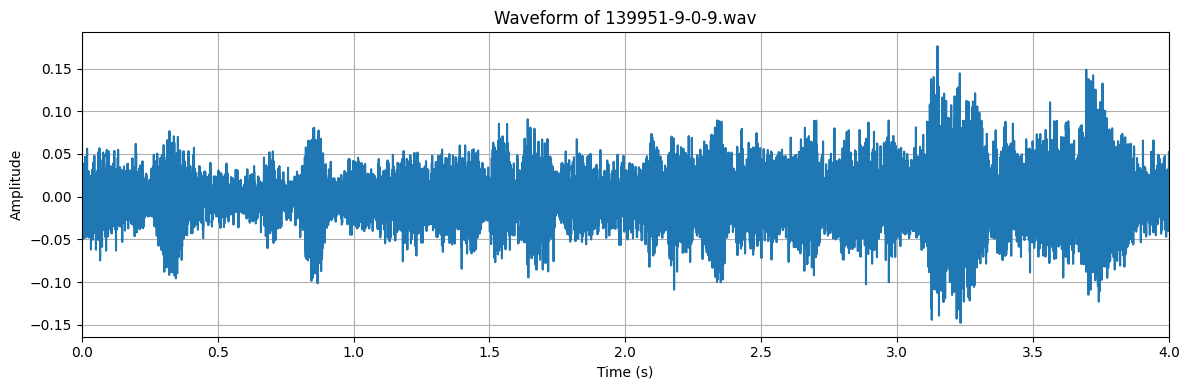

In [4]:
if waveform_native is not None and sr_native is not None:
    waveform_np = waveform_native.squeeze().numpy()
    num_samples = waveform_np.shape[0]
    time_axis = torch.linspace(0, num_samples / sr_native, steps=num_samples)

    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, waveform_np)
    plt.title(f'Waveform of {os.path.basename(audio_file_path)}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.xlim([0, num_samples / sr_native])
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot visualize waveform because audio failed to load.")

## 3. Preprocess Audio and Extract Features

Resample, pad/truncate, and convert the audio waveform into a log mel spectrogram using the imported function.

In [5]:
features = None
total_preprocess_time = 0
try:
    total_preprocess_start_time = time.time()
    # Call the imported function using the alias
    features = via.preprocess_audio_to_features(audio_file_path, audio_config)
    total_preprocess_time = time.time() - total_preprocess_start_time
    print(f"Total feature extraction time: {total_preprocess_time * 1000:.2f} ms")

except Exception as e:
    print(f"Error during audio preprocessing or feature extraction: {e}")
    if DEBUG:
        import traceback
        traceback.print_exc()


Processing audio file: /root/tidl/audioai-modelzoo/inference/vggish11_sc/sample_wav/139951-9-0-9.wav
  Waveform shape: torch.Size([1, 64000]), Preprocessing time: 0.0843s
  Log mel spectrogram shape: torch.Size([1, 64, 126]), Extraction time: 0.0225s
Total feature extraction time: 107.84 ms


Display the extracted features (Log Mel Spectrogram) that will be fed into the model.

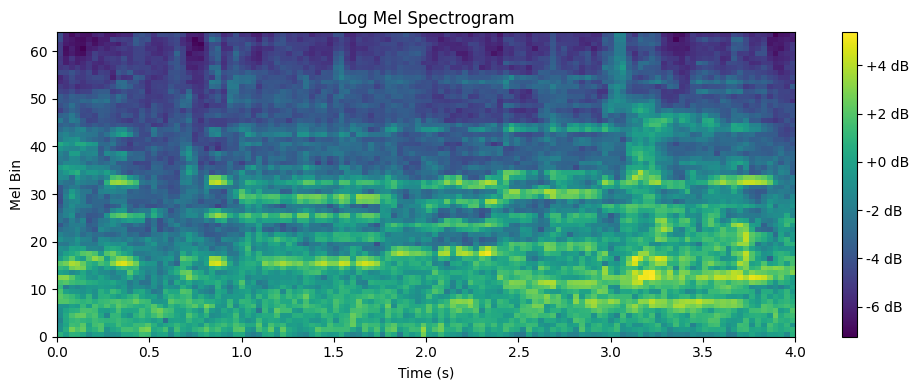

In [6]:
if features is not None:
    plt.figure(figsize=(10, 4))
    # Squeeze the batch dimension if it exists (e.g., shape [1, 64, 96] -> [64, 96])
    features_squeezed = np.squeeze(features)
    if features_squeezed.ndim == 2:
        # Use imshow for spectrogram display
        img = plt.imshow(features_squeezed, aspect='auto', origin='lower',
            extent=[0, audio_config['dataset']['duration'], 0, audio_config['dataset']['n_mels']])
        plt.colorbar(img, format='%+2.0f dB')
        plt.title('Log Mel Spectrogram')
        plt.xlabel('Time (s)')
        plt.ylabel('Mel Bin')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Cannot display spectrogram. Unexpected feature shape after squeeze: {features_squeezed.shape}")
else:
    print("Cannot visualize features because preprocessing failed.")

## 4. Run Inference

Load the ONNX model using ONNX Runtime with the TIDL delegate and perform inference using the imported function.

In [7]:
outputs = None
prediction_results = None
benchmark_results = None
sess = None

if features is not None and os.path.exists(model_path):
    try:
        # Set up inference session options
        delegate_options = {
            "artifacts_folder": artifacts_path,
            "debug_level": debug_level
        }
        session_options = ort.SessionOptions()
        session_options.log_severity_level = 3 # Error
        print(f"\nSetting up ONNX Runtime session for model: {model_name}")
        print(f"  Artifacts: {artifacts_path}")
        print(f"  Delegate options: {delegate_options}")

        # Create inference session
        EP_list = ['TIDLExecutionProvider', 'CPUExecutionProvider']
        sess = ort.InferenceSession(
            model_path,
            providers=EP_list,
            provider_options=[delegate_options, {}],
            sess_options=session_options
        )
        print("ONNX Runtime session created successfully.")

        # --- Run Inference using imported function via alias ---
        # The imported function will print prediction and benchmark reports
        outputs, prediction_results, benchmark_results = via.run_inference(sess, features)

    except Exception as e:
        print(f"Error during ONNX Runtime session creation or inference: {e}")
        if DEBUG:
            import traceback
            traceback.print_exc()
    finally:
        # Clean up session if it was created
        if sess:
            del sess
            print("\nONNX Runtime session released.")
else:
    print("Skipping inference: Features not generated or model file not found.")


Setting up ONNX Runtime session for model: vggish11_20250324-1807_ptq
  Artifacts: /root/tidl/audioai-modelzoo/model_artifacts/11_01_06_00/am62a/int8/vggish11_20250324-1807_ptq
  Delegate options: {'artifacts_folder': '/root/tidl/audioai-modelzoo/model_artifacts/11_01_06_00/am62a/int8/vggish11_20250324-1807_ptq', 'debug_level': 0}
EP Error /root/onnxruntime/onnxruntime/core/providers/tidl/tidl_execution_provider.cc:94 onnxruntime::TidlExecutionProvider::TidlExecutionProvider(const onnxruntime::TidlExecutionProviderInfo&) status == true was false. 
 when using ['TIDLExecutionProvider', 'CPUExecutionProvider']
Falling back to ['CPUExecutionProvider'] and retrying.
ONNX Runtime session created successfully.
Shape mismatch: features=(1, 64, 126), model=[1, 1, 64, 126]
  Reshaped features to [1, 1, 64, 126]
Inference time: 97.66 ms, Output shape: (1, 10)

Top predictions (softmax probabilities):
  1. Class 9 (Street music): 0.999992
  2. Class 2 (Children playing): 0.000008
  3. Class 0 (A

## 5. Summary

Final results and performance overview.

In [8]:
print("--- Inference Summary ---")
if prediction_results and benchmark_results:
    # Extract top prediction from the results dictionary returned by run_inference
    if prediction_results.get('top_predictions'):
        top_pred = prediction_results['top_predictions'][0]
        print(f"Audio File: {os.path.basename(audio_file_path)}")
        print(f"Model: {model_name} (int{tensor_bits})")
        # Access CLASS_LABELS via alias if needed here, though it's likely used within run_inference
        print(f"\nTop Prediction: {top_pred['class_name']} (Class {top_pred['class_index']}) with confidence {top_pred['confidence']:.4f}")
    else:
        print("Top prediction data not found in results.")

    # Extract performance metrics from the results dictionary
    print(f"\nPre-processing & Feature Extraction Time: {total_preprocess_time*1000:.2f} ms")
    print(f"Inference Time: {benchmark_results.get('inference_time_ms', 'N/A'):.2f} ms")
    print(f"TIDL Processing Time: {benchmark_results.get('processing_time_ms', 'N/A'):.2f} ms")
else:
    print("Inference did not complete successfully or results were not captured. No summary available.")

print("\nNotebook execution finished.")

--- Inference Summary ---
Audio File: 139951-9-0-9.wav
Model: vggish11_20250324-1807_ptq (int8)

Top Prediction: Street music (Class 9) with confidence 1.0000

Pre-processing & Feature Extraction Time: 107.84 ms
Inference Time: 97.66 ms
TIDL Processing Time: 0.00 ms

Notebook execution finished.
